<a href="https://colab.research.google.com/github/tianyu-lu/structure-generation/blob/master/transformer-xl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Huggingface Transformers

In [0]:
from torch.utils.data import Dataset, DataLoader, RandomSampler, TensorDataset
import glob

In [2]:
!pip install transformers

import os
import glob
import numpy as np
import random
import time
import datetime
import logging
logging.basicConfig(level=logging.INFO)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, TensorDataset
from torch.autograd import Variable
from transformers import GPT2LMHeadModel, GPT2Config, AdamW
from transformers import TransfoXLLMHeadModel, TransfoXLConfig
from transformers import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
from google.colab import drive

drive_name = '/content/drive'
drive.mount(drive_name)
drive_folder = ''
drive_location = drive_name + '/My Drive/' + drive_folder  # Change this to where your files are located

data_location = drive_location + '/'

INFO:transformers.file_utils:PyTorch version 1.5.0+cu101 available.
INFO:transformers.file_utils:TensorFlow version 2.2.0 available.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
%cd $data_location

!pwd
!cp /content/drive/'My Drive'/cath.tar.gz /content/
%cd /content/
!tar -xzf cath.tar.gz

/content/drive/My Drive
/content/drive/My Drive
/content


In [4]:
seed_val = 777
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def to_var(tensor):
    return Variable(tensor)

# for f in fnames:
#     if f.endswith("npy"):
#         a = np.load(f, allow_pickle=True)
#         length = int(a[0,0]*3)
#         inputs.append((length, a[1:length+4]))
# inputs.sort(key=lambda x: x[0])

# use first n-1 to predict last n-1 by prepadding the short sequences
# train_data = []
# for i in range(batch_size-1, len(inputs), batch_size):
#     train_batch = []
#     max_len_in_batch = 1024
#     for j in range(i-batch_size+1, i+1):
#         curr_len = inputs[j][0] + 1
#         if max_len_in_batch > curr_len:
#             prepad = np.zeros((max_len_in_batch - curr_len, 4))
#             # print("before:", prepad.shape)
#             # print("curr_len: ", curr_len)
#             # print("actual len:", len(inputs[j][1]))
#             # print(inputs[j][1])
#             prepad = np.concatenate((prepad, inputs[j][1]), axis=0)
#             # print("after", prepad.shape)
#             # print("len(prepad)", len(prepad))
#             # print("max_len_in_batch", max_len_in_batch)
#             # print("")
#             assert len(prepad) == max_len_in_batch
#             train_batch.append(prepad)
#         elif max_len_in_batch == curr_len:
#             assert len(inputs[j][1]) == max_len_in_batch
#             train_batch.append(inputs[j][1])
#         else:
#             print("maxlen:", max_len_in_batch)
#             print("currlen:", curr_len)
#             raise ValueError
#     train_data.append(train_batch)

# use Transformer-XL to account for variable sequence lengths and contexts

files = glob.glob("*.npy")
print(len(files))
random.shuffle(files)
split = int(0.8 * len(files))
train_files = files[:split]
val_files = files[split:]

# when using the dataloader, just set batch_size=1, since we are already forming
# the batches here
batch_size = 8
class ProteinDataset(Dataset):
    def __init__(self, mode, batch_size=8):
        self.batch_size = batch_size
        if mode == 'train':
            self.files = train_files
        else:
            self.files = val_files

    def __getitem__(self, i):
        #print("getting item")
        curr_batch = []
        adj_idx = i % len(self.files)
        fnames = self.files[adj_idx: adj_idx + self.batch_size]
        i = 1
        max_len = 0
        while len(fnames) < self.batch_size:
            fnames.append(self.files[adj_idx - i])
            i += 1
        #print("final fnames", fnames)
        for f in fnames:
            try:
                p = np.load(f)
            except:
                continue
            curr_batch.append(p)
            if len(p) > max_len:
                max_len = len(p)
        for i, p in enumerate(curr_batch):      # prepend with zeros
            pad_len = max_len - len(p)
            if pad_len > 0:
                curr_batch[i] = np.concatenate((np.zeros((pad_len, 4)), p), axis=0)
        return to_var(torch.FloatTensor(curr_batch))

    def __len__(self):
        return len(self.files)

train_data = ProteinDataset('train', batch_size=batch_size)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=1)

val_data = ProteinDataset('validation', batch_size=batch_size)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=1)

39346


In [5]:
print(len(train_data))

31476


In [0]:
  # def ce_and_mse(logits, coords, targets):
#     t_id = targets[:, :, 0]

#     logits = logits.view(-1,20)
#     t_id = t_id.reshape((-1,1)).squeeze()

#     t_id = t_id.type(torch.LongTensor)
#     t_id = to_var(t_id)

#     ce_func = nn.CrossEntropyLoss()
#     ce_loss = ce_func(logits, t_id)
#     mse_func = nn.MSELoss()
#     mse_loss = mse_func(coords, targets[:, :, 1:])

#     return ce_loss + mse_loss

class XL_Protein(TransfoXLLMHeadModel):
    def __init__(self, config):
        super(XL_Protein, self).__init__(config)
        
        self.aa_layer = nn.Embedding(23, int(config.d_embed/2))  # may need to be Long
        self.coord_layer = nn.Linear(3, int(config.d_embed/2))
        self.coord_out = nn.Linear(config.d_model, 3, bias=False)

    # labels only include the aa indices (including mask (-100), start, stop tokens)
    def forward(self, input_ids=None, mems=None, head_mask=None, inputs_embeds=None, labels=None, coords=None):
        bsz, tgt_len = input_ids.size(0), input_ids.size(1)
        aa_embed = input_ids[:, :, 0].type(torch.LongTensor).squeeze().cuda()
        aa_embed = self.aa_layer(aa_embed)
        coord_embed = input_ids[:,:,1:].cuda()
        coord_embed = self.coord_layer(coord_embed)
        # print("aa_embed", aa_embed.shape)
        # print("coord_embed", coord_embed.shape)
        input_embeds = torch.cat((aa_embed, coord_embed), dim=2)
        transformer_outputs = self.transformer(input_ids=None, mems=mems, head_mask=head_mask, inputs_embeds=input_embeds)

        last_hidden = transformer_outputs[0]
        pred_hid = last_hidden[:, -tgt_len:]
        outputs = transformer_outputs[1:]

        softmax_output = self.crit(pred_hid, labels)  # predicting aa
        coord_pred = self.coord_out(pred_hid)       # predicting coords from the same hidden states (should this be split?)
        mse = nn.MSELoss()
        coords_loss = mse(coords, coord_pred)
        #print("coords loss shape", coords_loss.shape)

        if labels is None:
            softmax_output = softmax_output.view(bsz, tgt_len, -1)
            outputs = [softmax_output, coord_pred] + outputs
        else:
            softmax_output = softmax_output.view(bsz, tgt_len - 1)
            loss =  softmax_output.mean() + coords_loss
            outputs = [loss, coord_pred] + outputs

        return outputs

class GPT_Protein(GPT2LMHeadModel):
    def __init__(self, config):
        super(GPT_Protein, self).__init__(config)

        self.embedding = nn.Embedding(23, int(config.n_embd/2))  # may need to be Long

        self.coord_layer = nn.Linear(3, int(config.n_embd/2))

        self.lm_head_override = nn.Linear(config.n_embd, 23+3, bias=False)

    def forward(
        self,
        input_ids=None,
        past=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
    ):
        embed_in = input_ids[:, :, 0].type(torch.LongTensor).squeeze().cuda()
        # print("trying to embed")
        # print(embed_in[0])
        embed = self.embedding(embed_in).cuda()
        coord_in = input_ids[:,:,1:].cuda()

        self.coord_layer = self.coord_layer.cuda()
        coord_in = self.coord_layer(coord_in)
        #print(embed.shape)
        #print(coord_in.shape)
        input_embeds_transf = torch.cat((embed, coord_in), dim=2)
        #print(input_embeds_transf.shape)

        transformer_outputs = self.transformer(
            input_ids=None,
            past=past,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=input_embeds_transf,
        )
        hidden_states = transformer_outputs[0]
        #print("hidden states: ", hidden_states.shape)
        lm_out = self.lm_head_override(hidden_states)
        #print("lm_out: ", lm_out.shape)
        lm_logits = lm_out[:,:,:23]
        lm_coords = lm_out[:,:,23:].cuda()
        outputs = (lm_logits, lm_coords,) + transformer_outputs[1:]
        if labels is not None:
            real_aas = labels[:,:,0].squeeze()
            real_coords = labels[:,:,1:].cuda()
            # Shift so that tokens < n predict n
            #print("lm_logits: ", lm_logits.shape)
            shift_logits = lm_logits[..., :-1, :].contiguous()
            #print("shift_logits: ", shift_logits.shape)
            shift_labels = real_aas[..., 1:].contiguous()
            # Flatten the tokens
            ce_loss = nn.CrossEntropyLoss()
            pred = shift_logits.view(-1, shift_logits.size(-1)).cuda()
            target = shift_labels.view(-1)
            target = target.type(torch.LongTensor).cuda()
            # print("pred: ", pred)
            # print("target: ", target)
            loss = ce_loss(pred, target)
            mse_loss = nn.MSELoss()
            loss += mse_loss(lm_coords, real_coords)
            outputs = (loss,) + outputs

        return outputs  # (loss), lm_logits, presents, (all hidden_states), (attentions)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

aa_to_int = {"I":1, "V":2, "L":3, "F":4, "C":5, "M":6, "A":7, "G":8, "T":9, "S":10,
             "W":11, "Y":12, "P":13, "H":14, "E":15, "Q":16, "D":17, "N":18, "K":19, "R":20,
             "<START>":21, "<END>":22, "<PAD>":0}
idx_to_aa = {1:"I", 2:"V", 3:"L", 4:"F", 5:"C", 6:"M", 7:"A", 8:"G", 9:"T", 10:"S", 
             11:"W", 12:"Y", 13:"P", 14:"H", 15:"E", 16:"Q", 17:"D", 18:"N", 19:"K", 20:"R", 
             21:"<START>", 22:"<END>", 0:"<PAD>"}
# for key in aa_to_int:
#     print(str(aa_to_int[key]) + ":\"" + key + "\"", end=', ')

def train_model(model_type='XL'): 

    if model_type == 'XL':
        config = TransfoXLConfig(vocab_size=23, cutoffs=[8, 13, 22],
                                 d_model=64, d_embed=64, n_head=1, d_head=16, 
                                 d_inner=128, div_val=4, pre_lnorm=False, n_layer=3, 
                                 tgt_len=128, ext_len=0, mem_len=1600, clamp_len=1000, 
                                 same_length=False, proj_share_all_but_first=True, attn_type=0, 
                                 sample_softmax=- 1, adaptive=True, tie_weight=True, dropout=0.1, 
                                 dropatt=0.0, untie_r=True, init='normal', init_range=0.01, 
                                 proj_init_std=0.01, init_std=0.02, layer_norm_epsilon=1e-05, 
                                 eos_token_id=22)
        model = XL_Protein(config)
    else:
        #model = GPT_Protein.from_pretrained("gpt2")
        config = GPT2Config(vocab_size=23, n_positions=1024, n_ctx=1024, n_embd=128, 
                  n_layer=4, n_head=4, activation_function='gelu_new', 
                  resid_pdrop=0.1, embd_pdrop=0.1, attn_pdrop=0.1, layer_norm_epsilon=1e-05, 
                  initializer_range=0.02, summary_type='cls_index', summary_use_proj=True, 
                  summary_activation=None, summary_proj_to_labels=True, summary_first_dropout=0.1, 
                  bos_token_id=21, eos_token_id=22)
        model = GPT_Protein(config)

    model.float()
    model.cuda()   
    optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

    total_steps = int(len(train_data) / batch_size)  # i.e. number of batches
    # scheduler = get_linear_schedule_with_warmup(optimizer, 
    #                                         num_warmup_steps = 0, 
    #                                         num_training_steps = total_steps)
    train_loss = []
    val_loss = []

    num_epochs = 100
    try:
        for epoch_i in range(0, num_epochs):
            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_epochs))
            t0 = time.time()

            total_loss = 0
            model.train()

            for i, b_input_ids in enumerate(train_dataloader):
                # print("b_input_ids", b_input_ids.shape)
                b_input_ids = b_input_ids.squeeze(dim=0)
                # b_input_ids = torch.FloatTensor(np.array(b_input_ids))
                seq_len = b_input_ids.shape[1]
                labels = b_input_ids[:,:,0].type(torch.LongTensor).squeeze().cuda()
                coords = b_input_ids[:,:,1:].cuda()
                outputs = model(input_ids=b_input_ids, mems=None, head_mask=None, inputs_embeds=None, labels=labels, coords=coords)

                loss = outputs[0]
                total_loss += loss.item() / seq_len

                model.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

                optimizer.step()
                # scheduler.step()

                if (i + 1) % 100 == 0:
                    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                        epoch_i + 1, 
                        num_epochs, 
                        i + 1, 
                        total_steps,
                        loss.item())
                      )

            avg_train_loss = total_loss / total_steps * 100  # just for scaling purposes
            train_loss.append(avg_train_loss)

            print("")
            print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
                

            print("Running Validation...")

            # t0 = time.time()
            model.eval()

            eval_loss, eval_accuracy = 0, 0
            best_loss = 10000
            nb_eval_steps, nb_eval_examples = 0, 0

            for i, b_input_ids in enumerate(val_dataloader):
                b_input_ids = b_input_ids.squeeze(dim=0)
                seq_len = b_input_ids.shape[1]
                labels = b_input_ids[:,:,0].type(torch.LongTensor).squeeze().cuda()
                coords = b_input_ids[:,:,1:].cuda()
                with torch.no_grad(): 
                    outputs = model(input_ids=b_input_ids, mems=None, head_mask=None, inputs_embeds=None, labels=labels, coords=coords)
                curr_val_loss, coord_pred, logits = outputs
            #     # logits = logits.detach().cpu().numpy()
            #     # coords = coords.detach().cpu().numpy()
            #     # target_vals = b_labels.to('cpu').numpy()
                
                eval_loss += curr_val_loss.item() / seq_len
                nb_eval_steps += 1

            if eval_loss < best_loss:
                best_loss = eval_loss
                torch.save(model.state_dict(), "best_model.pt")
            avg_val_loss = eval_loss/nb_eval_steps * 100  # for scaling
            val_loss.append(avg_val_loss)
            print("  Validation loss: {0:.2f}".format(avg_val_loss))
            # print("  Validation took: {:}".format(format_time(time.time() - t0)))
        print("")
        print("Training complete.")
    except KeyboardInterrupt:
        print("Early exit from training.")
        return train_loss, val_loss
    return train_loss, val_loss


def plot_loss(train_loss, val_loss):
    sns.set(style='darkgrid')
    sns.set(font_scale=2.5)
    plt.rcParams["figure.figsize"] = (12,6)
    plt.plot(train_loss, 'b-o')
    plt.plot(val_loss, 'r-o')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

In [0]:
!cp best_model.pt /content/drive/'My Drive'/


======== Epoch 1 / 100 ========
Epoch [1/100], Step [100/3934.5], Loss: 2.6896
Epoch [1/100], Step [200/3934.5], Loss: 2.7210
Epoch [1/100], Step [300/3934.5], Loss: 1.7356
Epoch [1/100], Step [400/3934.5], Loss: 1.2617
Epoch [1/100], Step [500/3934.5], Loss: 2.1057
Epoch [1/100], Step [600/3934.5], Loss: 1.9421
Epoch [1/100], Step [700/3934.5], Loss: 1.3050
Epoch [1/100], Step [800/3934.5], Loss: 1.0430
Epoch [1/100], Step [900/3934.5], Loss: 1.3087
Epoch [1/100], Step [1000/3934.5], Loss: 1.2361
Epoch [1/100], Step [1100/3934.5], Loss: 0.6849
Epoch [1/100], Step [1200/3934.5], Loss: 1.2391
Epoch [1/100], Step [1300/3934.5], Loss: 1.1036
Epoch [1/100], Step [1400/3934.5], Loss: 1.0907
Epoch [1/100], Step [1500/3934.5], Loss: 0.7731
Epoch [1/100], Step [1600/3934.5], Loss: 1.0367
Epoch [1/100], Step [1700/3934.5], Loss: 0.5878
Epoch [1/100], Step [1800/3934.5], Loss: 0.6031
Epoch [1/100], Step [1900/3934.5], Loss: 1.1069
Epoch [1/100], Step [2000/3934.5], Loss: 1.2622
Epoch [1/100], S

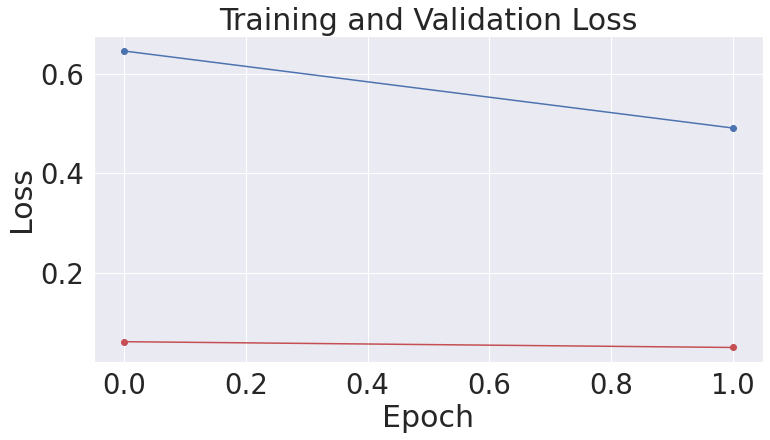

In [7]:
train_loss, val_loss = train_model()
plot_loss(train_loss, val_loss)